**APPL stock rice prediction using LSTM Model**

By: Babak Ahmadi

Email Address: babak.ahmadi.iust@gmail.com


The project provides a tool for amateur stock traders by predicting the APPL stock price volatility.

Amateur stock traders always look for market predictions to decide their next moves. Given the rich price history of APPL since 1980s, the data base provides a good basis to predict the behavior of the price in future based on the most recent price trend. 

Following packages and tools are used in this notebook:

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import yfinance as yf
from yahoofinancials import YahooFinancials as yfin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.layers import Dense, Dropout
from datetime import datetime, timedelta, date
import math

We are defining globar variables to be used in this notebook

In [2]:
#input_Data
Price=1   #Price history used as input 1, 0 othrwise 
stck_pr_drop=['Open','High','Low','Adj Close','Volume'] #Dropping price history features 
FinStmnt=0 # Financial statements to be used as inpt 1, 0 otherwise 
#Features of financial statements to be dropped 
stmn_drop=['OperatingIncome','\tNetIncome','NetIncomeFromContinuingOperationNetMinorityInterest',
           'ReconciledDepreciation','ReconciledCostOfRevenue','OperatingExpense',
           'TotalOperatingIncomeAsReported','DilutedAverageShares','BasicEPS',
           'DilutedNIAvailtoComStockholders','\t\t\tNetIncomeContinuousOperations',
           '\t\t\tNetIncomeExtraordinary','\t\t\tNetIncomeFromTaxLossCarryforward',
           '\t\tNetIncomeIncludingNoncontrollingInterests','NetIncomeCommonStockholders',
           '\tOtherNonOperatingIncomeExpenses','TaxProvision','PretaxIncome',
           '\t\tRestructuringAndMergernAcquisition','\t\tOtherSpecialCharges','\tGainOnSaleOfSecurity',
           '\tSpecialIncomeCharges','\tTotalOtherFinanceCost','\tInterestIncomeNonOperating',
           'NetNonOperatingInterestIncomeExpense','CostOfRevenue',
           '\tDepreciationAmortizationDepletionIncomeStatement','\t\tDepreciationAndAmortizationInIncomeStatement', 
           '\tOtherOperatingExpenses', 'TotalUnusualItemsExcludingGoodwill', 'TotalUnusualItems', 
           'TaxRateForCalcs', 'TaxEffectOfUnusualItems','EBITDA',
           '\tOperatingRevenue','NetIncomeFromContinuingAndDiscontinuedOperation',
           'InterestIncome','InterestExpense']
stmn_drop_col=['ttm']
Interes_Rate=0 #interest rate to be used 1, 0 otherwise
Inflation=0 #inflation rate to be used 1, 0 otherwise 
#FillNaN
Zero=1 
Prev=0
#Graphic
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#Norm
mean_std=1
std=0
mean=0
#day to be predicted
n_future=1 
#number of days to be used from past
n_past=14  
#date to separate price history used for test
sepdate=datetime(2018, 1, 1)

First step is using Yahoo finance API to download the most the most recent stock price history. After pre-processing the data, we prepare the input data in the format of a matrix with rows being the number of samples and columns being the number of days from past used in LSTM model to predict the future price. 

In [3]:
ticker='AAPL'
aapl_fin_stmst=yfin(ticker)
aapl_fin=yf.Ticker("AAPL")

In [4]:
if Price==1:
    stck_pr=yf.download("aapl", period="max", interval="1d")
    stck_pr.drop(stck_pr_drop, axis=1, inplace = True)
    stck_pr.index=pd.to_datetime(stck_pr.index).strftime('%Y-%m-%d')
   

[*********************100%***********************]  1 of 1 completed


In [5]:
if FinStmnt==1:
    stmn=pd.read_csv('AAPL_quarterly_financials.csv')
    name=stmn.name
    stmn=stmn.replace(",","", regex=True)
    stmn=stmn.apply(pd.to_numeric, errors='coerce')
    stmn.name=name
    stmn.drop(stmn_drop_col, axis=1, inplace = True)
    stmn=stmn.T.rename({'name':'Date'})
    lables=stmn.iloc[0]
    stmn.columns=lables
    stmn=stmn.iloc[1: , :]
    stmn.drop(stmn_drop, axis=1, inplace = True)
    stmn.index = pd.to_datetime(stmn.index).strftime('%Y-%m-%d')
    aapl_earnings_hist = pd.DataFrame(si.get_earnings_history("aapl"))
    aapl_earnings_hist=pd.to_datetime(aapl_earnings_hist['startdatetime']).dt.date
    aapl_earnings_hist=aapl_earnings_hist[aapl_earnings_hist< date.today()]
    aapl_earnings_hist.index=aapl_earnings_hist
    aapl_earnings_hist=aapl_earnings_hist[::-1]
    stmn_cl=stmn[::-1]
    stmn_cl=pd.merge(stmn_cl, aapl_earnings_hist, how='outer', left_index=True, right_index=True)
    stmn_cl['Date']=pd.to_datetime(stmn_cl.index)
    stmn_cl.sort_values(by='Date', inplace=True)
    Date_fixed=stmn_cl.Date
    Date_fixed1=Date_fixed[Date_fixed>=pd.to_datetime(aapl_earnings_hist).min()]
    Date_fixed2=Date_fixed[Date_fixed<pd.to_datetime(aapl_earnings_hist).min()]+timedelta(days=45)
    Date_fixed_final=pd.concat([Date_fixed2[:-1],Date_fixed1], axis=0)
    Date_fixed_final.index=Date_fixed_final
    Date_fixed_final.loc[['2002-06-30','2001-12-31','2001-09-30','2001-03-31','1994-08-14','1994-05-15','1993-11-14','1993-08-14','1993-05-15','1993-02-14','1992-11-14','1988-08-14','1988-05-15','1988-02-14','1987-11-14','1987-02-14']]=['2002-03-28','2001-09-28','2001-06-29','2000-12-29','1994-08-12','1994-05-13','1993-11-12','1993-08-13','1993-05-14','1993-02-12','1992-11-13','1988-08-12','1988-05-13','1988-02-12','1987-11-13','1987-02-13']
    stmn_cl=stmn_cl.iloc[:-1 , :]
    stmn_cl.index=Date_fixed_final
    stmn_cl.drop(['Date', 'startdatetime'], axis=1, inplace = True)
    stmn_cl.dropna(axis=0, how='all', inplace = True)
    stmn_cl.index=pd.to_datetime(stmn_cl.index).strftime('%Y-%m-%d')

In [6]:
if FinStmnt==1:
    data=pd.merge(stck_pr, stmn_cl, how='outer', left_index=True, right_index=True)
else:
    data=stck_pr

In [7]:
if Interes_Rate==1:
    IR=pd.read_csv('PRIME.csv')
    IR.index=IR.DATE
    IR.drop('DATE', axis=1, inplace=True)
    IR=IR.apply(pd.to_numeric, errors='coerce')
    data=pd.merge(data, IR, how='left', left_index=True, right_index=True)

In [8]:
if Inflation==1:
    INF=pd.read_csv('INF.csv')
    INF.index=INF.Date
    INF.drop('Date', axis=1, inplace=True)
    INF=INF.apply(pd.to_numeric, errors='coerce')
    INF.columns=['infl']
    INF.index = pd.to_datetime(INF.index, infer_datetime_format=True).strftime('%Y-%m-%d')
    data=pd.merge(data, INF, how='left', left_index=True, right_index=True)

In [9]:
cols=data.columns
date=pd.to_datetime(data.index)

In [10]:
#na_count=data.isna().sum()

In [11]:
mean=data.mean(axis=0, skipna=True)
std=data.std(axis=0, skipna=True)
print(mean)
print(std)

Close    17.171042
dtype: float64
Close    36.319533
dtype: float64


In [12]:
if mean_std==1:
    data_scl=(data-mean)/std
elif mean==1:
    data_scl=(data-mean)
elif std==1:
    data_scl=(data)/std
#data_scl

In [13]:
if Zero==1:
    datascl=data_scl.fillna(0, axis=1)
elif Prev==1:
    datascl=data_scl.fillna(method='ffill', axis=1)

In [14]:
#data_test = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
#scaler = StandardScaler()
#scaler = scaler.fit(data)
#datascl=scaler.transform(data)

In [15]:
data=pd.DataFrame(datascl.to_numpy())
data.columns=cols
data['Date']=date
data=data.dropna(axis=0, how='any')
datascl=datascl.dropna(axis=0, how='any').to_numpy()
#data=datascl

In [16]:
#data=datascl

#data.TotalRevenue[np.isnan(data.TotalRevenue) != 1]
#data

In [17]:
data_training=datascl[data.Date < sepdate]
data_pred=np.concatenate((data_training[-n_past:], datascl[data.Date >= sepdate]),axis=0)
date_pred=data.Date[data.Date >= sepdate]

In [18]:
trainX =[]
trainY =[]

for i in range(n_past, len(data_training) - n_future + 1):
    trainX.append(data_training[i - n_past:i, 0:data_training.shape[1]])
    trainY.append(data_training[i + n_future - 1:i + n_future, 0])

#data_pred=np.append(data_training[len(data_training)-n_past+1:len(data_training)+1],data_pred)
predX =[]
predY =[]    
#predX.append(data_pred[n_past - n_past:n_past , 0:data_pred.shape[1]])
for i in range(n_past, len(data_pred) - n_future + 1):
    predX.append(data_pred[i - n_past:i , 0:data_pred.shape[1]])
    predY.append(data_pred[i + n_future - 1:i + n_future,0])

trainX, trainY = np.array(trainX), np.array(trainY)

predX, predY = np.array(predX), np.array(predY)

In [19]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('predX shape == {}.'.format(predX.shape))
print('predY shape == {}.'.format(predY.shape))

trainX shape == (9330, 14, 1).
trainY shape == (9330, 1).
predX shape == (1316, 14, 1).
predY shape == (1316, 1).


At the second step, we build an LSTM model using TensorFlow Keras and feed the data prepared in step one. We use the last two years for test data by separating them from the train data and only using them at the test stage. 

In [20]:
model = Sequential()
model.add(LSTM(512, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(LSTM(1024, activation='relu',input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(LSTM(512, activation='relu',input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(LSTM(256, activation='relu',input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

2023-03-26 10:21:06.309104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 128)               328192    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,380,993
Trainable params: 1,380,993
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(trainX, trainY, epochs=10)

Epoch 1/10
292/292 [==============================] - 49s 158ms/step - loss: 0.0036
Epoch 2/10
292/292 [==============================] - 48s 166ms/step - loss: 7.9636e-04
Epoch 3/10
292/292 [==============================] - 49s 168ms/step - loss: 7.4338e-04
Epoch 4/10
292/292 [==============================] - 48s 164ms/step - loss: 7.0340e-04
Epoch 5/10
292/292 [==============================] - 48s 164ms/step - loss: 6.5405e-04
Epoch 6/10
292/292 [==============================] - 49s 167ms/step - loss: 6.3142e-04
Epoch 7/10
292/292 [==============================] - 49s 167ms/step - loss: 5.4462e-04
Epoch 8/10
292/292 [==============================] - 50s 170ms/step - loss: 5.0693e-04
Epoch 9/10
292/292 [==============================] - 48s 166ms/step - loss: 5.6402e-04
Epoch 10/10
292/292 [==============================] - 48s 164ms/step - loss: 4.9854e-04


In [22]:
history.history

{'loss': [0.003594831330701709,
  0.0007963578682392836,
  0.0007433759747073054,
  0.0007033952861092985,
  0.0006540542817674577,
  0.0006314172060228884,
  0.0005446156719699502,
  0.0005069270264357328,
  0.0005640239105559886,
  0.0004985400591976941]}

In [23]:
predict=model.predict(predX)
accu=model.evaluate(predX, predY)

42/42 [==============================] - 2s 43ms/step - loss: 0.0342


In [24]:
Y_predict=pd.DataFrame(predict*std['Close']+mean['Close'])
Y_predict.columns=['closed_pred']

At the final step, we compare the real data from the last five years to the predicted price by the model. The result is shown in the diagrams in the Jupyter Notebook. 

In [35]:
stck_pr_full=yf.download("aapl", start=datetime(2023, 3, 1),end=None, interval="1d")

[*********************100%***********************]  1 of 1 completed


,closed,Y_predict,ratio,shift
0,43.064999,42.798290,1.006232,0.266708
1,43.057499,42.824371,1.005444,0.233128
2,43.257500,42.872467,1.008981,0.385033
3,43.750000,42.968670,1.018184,0.781330
4,43.587502,43.171642,1.009633,0.415859
5,43.582500,43.297794,1.006576,0.284706
6,43.572498,43.379837,1.004441,0.192661
7,43.820000,43.432095,1.008931,0.387905
8,44.272499,43.527084,1.017125,0.745415
9,44.047501,43.714497,1.007618,0.333004


<Figure size 640x480 with 0 Axes>

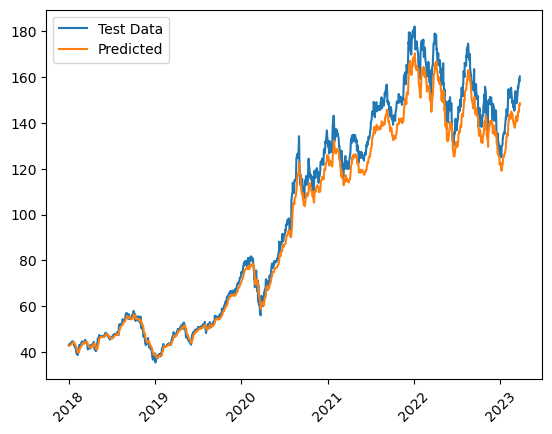

In [25]:
X=pd.DataFrame(pd.to_datetime(date_pred))
Y=pd.DataFrame(predY*std['Close']+mean['Close'])
Y.columns=['closed']
check=Y
check['Y_predict']=Y_predict.closed_pred
#check['Y_predict_D']=Y_predictD.closed_pred
check['ratio']=check.closed/check.Y_predict
check['shift']=check.closed-check.Y_predict
fig = plt.figure()
fig, ax = plt.subplots()
line1, =ax.plot(X['Date'],Y['closed'], label='Test Data')
line2, =ax.plot(X['Date'],Y_predict['closed_pred'], label='Predicted')
#line3, =ax.plot(X['Date'],Y_predictD['closed_pred'], label='Predicted_D')
plt.xticks(rotation = 45)
ax.legend(handles=[line1, line2])#, line3])
check

In [73]:
Y_predict_cndl = Y_predict[-stck_pr_full.index.size:]

In [74]:
X_cndl = pd.DataFrame(pd.to_datetime(stck_pr_full.index))

In [80]:
Y_predict

,closed_pred
0,42.798290
1,42.824371
2,42.872467
3,42.968670
4,43.171642
5,43.297794
6,43.379837
7,43.432095
8,43.527084
9,43.714497


In [76]:
stck_pr_full.size

108

In [77]:
stck_pr_full.index

DatetimeIndex(['2023-03-01', '2023-03-02', '2023-03-03', '2023-03-06',
               '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10',
               '2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16',
               '2023-03-17', '2023-03-20', '2023-03-21', '2023-03-22',
               '2023-03-23', '2023-03-24'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [90]:
predX

array([[[0.71577071],
        [0.70909385],
        [0.71301741],
        ...,
        [0.70152223],
        [0.70482621],
        [0.69209197]],

       [[0.70909385],
        [0.71301741],
        [0.71267322],
        ...,
        [0.70482621],
        [0.69209197],
        [0.71294851]],

       [[0.71301741],
        [0.71267322],
        [0.72471908],
        ...,
        [0.69209197],
        [0.71294851],
        [0.71274202]],

       ...,

       [[3.54462051],
        [3.68559135],
        [3.76268493],
        ...,
        [3.79489895],
        [3.86097893],
        [3.91274184]],

       [[3.68559135],
        [3.76268493],
        [3.70128558],
        ...,
        [3.86097893],
        [3.91274184],
        [3.87281851]],

       [[3.76268493],
        [3.70128558],
        [3.73625269],
        ...,
        [3.91274184],
        [3.87281851],
        [3.90310499]]])

<Figure size 640x480 with 0 Axes>

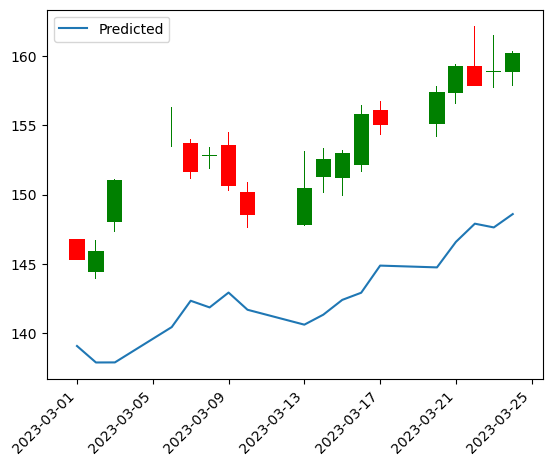

In [83]:
#create figure
pltcandle = plt.figure()

pltcandle, axx = plt.subplots()

line3, =axx.plot(X_cndl,Y_predict_cndl['closed_pred'], label='Predicted')

#define width of candlestick elements
width = .8
width2 = .05

#define up and down prices
up = stck_pr_full[stck_pr_full.Close>=stck_pr_full.Open]
down = stck_pr_full[stck_pr_full.Close<stck_pr_full.Open]

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

#plot down prices
plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')
axx.legend(handles=[line3])#, line3])

#display candlestick chart
plt.show()

Using price history since 2021, predicted stock price and actual stock price is shown below:
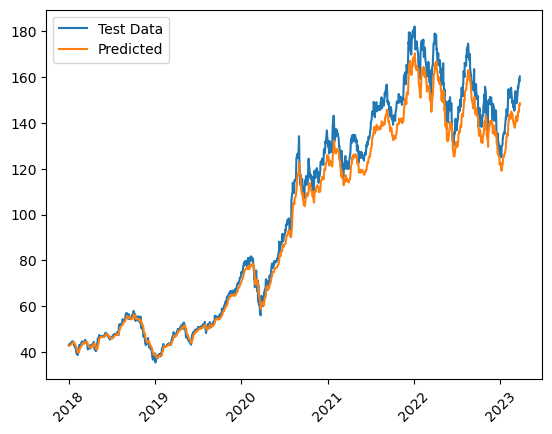

Overlaying the predicted price graph with real price candle sticks as below shows that, although the predicted price graph is not in the range of candle sticks but it is accurately predicting the volatility of the price which could help predict the marke behaviour.


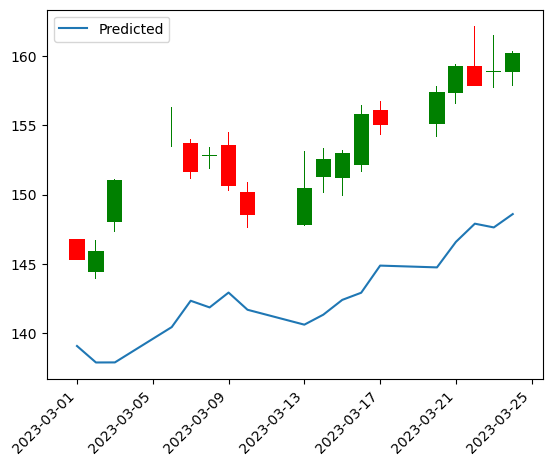

However, using predicted value starting 2018, predicted stock price and actual stock price is shown below:
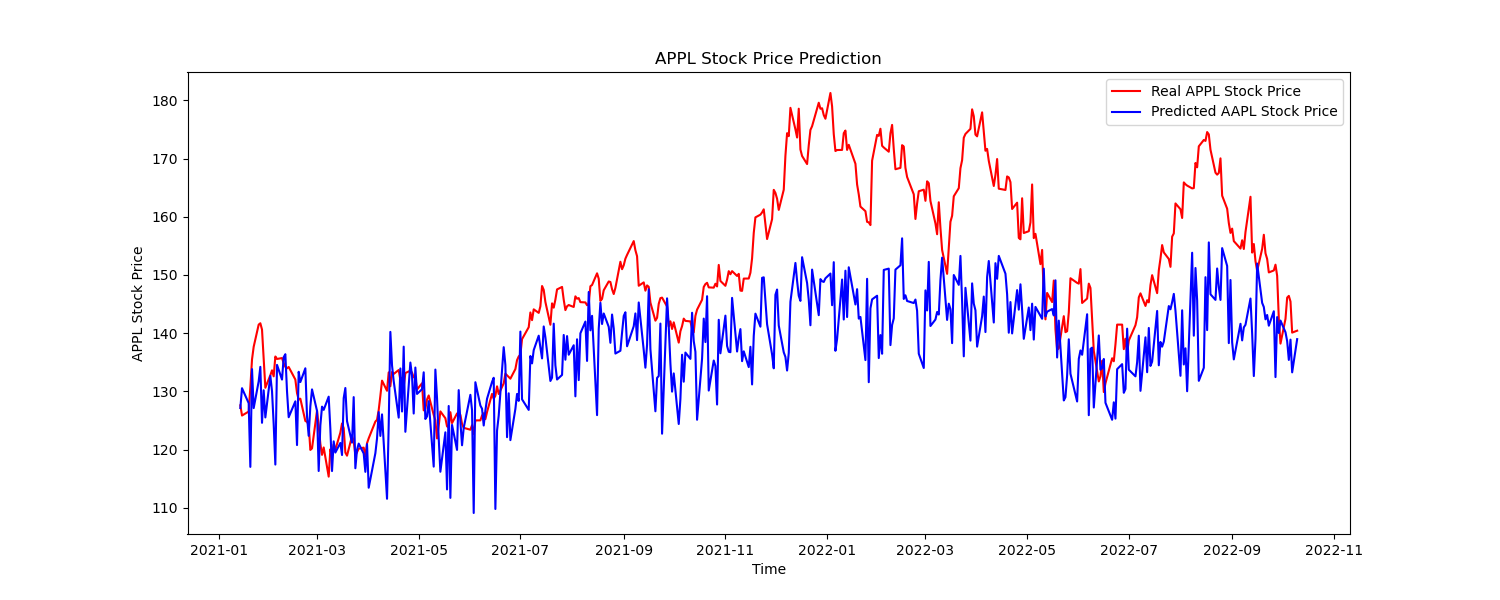

In [28]:
model.save('/Users/babakahmadi/Documents/apple/final-model')

INFO:tensorflow:Assets written to: /Users/babakahmadi/Documents/apple/final-model/assets


In [91]:
std['Close']

36.31953317591333

In [92]:
mean['Close']

17.171041553941734

In [93]:
predict

array([[0.7056051],
       [0.7063232],
       [0.7076474],
       ...,
       [3.5994465],
       [3.5919924],
       [3.6185474]], dtype=float32)